<a href="https://colab.research.google.com/github/Rubnserrano/TF-Certification/blob/main/03_curso_tf_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.
+ more things following Nicholas Renotte video "Build a Deep CNN Image Classifier with ANY Images" 

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 511.8 MB 10 kB/s 


## Previously download +300 images of each label (with chrome extension) and upload to cloud 

In [2]:
import tensorflow as tf
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My Drive/dog_classifier/data
# data_dir = 'drive/My Drive/dog_classifier/data'
!ls

/content/drive/My Drive/dog_classifier/data
bulldog  dachshund


In [4]:
import cv2
import imghdr

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
data_dir = '/content/drive/MyDrive/dog_classifier/data'

In [7]:
os.listdir(data_dir)

['dachshund', 'bulldog']

In [8]:
os.listdir(os.path.join(data_dir, 'bulldog'))
len(os.listdir(os.path.join(data_dir, 'bulldog')))

293

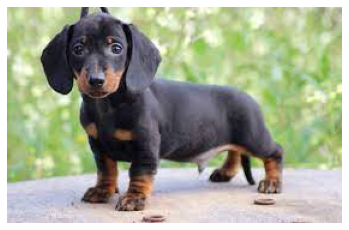

In [9]:
import matplotlib.pyplot as plt
img = cv2.imread(os.path.join(data_dir, 'dachshund', 'image29.jpeg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()

In [10]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))


In [11]:
for dirpath, dirnames, filenames in os.walk('/content/drive/MyDrive/dog_classifier'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/drive/MyDrive/dog_classifier'.
There are 2 directories and 0 images in '/content/drive/MyDrive/dog_classifier/data'.
There are 0 directories and 293 images in '/content/drive/MyDrive/dog_classifier/data/dachshund'.
There are 0 directories and 293 images in '/content/drive/MyDrive/dog_classifier/data/bulldog'.


#Data pipeline

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 586 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()
print(len(batch))
batch[1]

2


array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

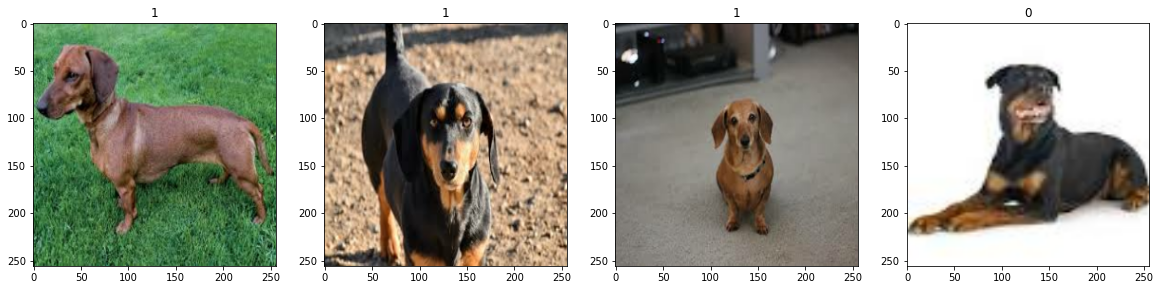

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# Preprocess data

##Scale

In [144]:
data = data.map(lambda x,y: (x/255.,y))

In [145]:
scaled_iterator = data.as_numpy_iterator()

In [146]:
len(data) #each batch contains 32 images

19

In [147]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1
train_size, val_size, test_size

(13, 4, 2)

Data is already shuffled, it not, do it before train test split

In [148]:
train = data.take(train_size)
val = data.skip(train_size).take(test_size)
test = data.skip(train_size).take(val_size)

In [149]:
len(train)

13

#Model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [44]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))


In [47]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [48]:
logdir = 'logs'

In [49]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [51]:
hist = model.fit(train, epochs=10, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/10
13/13 [==============================] - 31s 2s/step - loss: 0.5178 - accuracy: 0.7692 - val_loss: 0.4421 - val_accuracy: 0.8125
Epoch 2/10
13/13 [==============================] - 31s 2s/step - loss: 0.4008 - accuracy: 0.8197 - val_loss: 0.3062 - val_accuracy: 0.9062
Epoch 3/10
13/13 [==============================] - 32s 2s/step - loss: 0.3506 - accuracy: 0.8654 - val_loss: 0.2627 - val_accuracy: 0.9062
Epoch 4/10
13/13 [==============================] - 27s 2s/step - loss: 0.3141 - accuracy: 0.8894 - val_loss: 0.2803 - val_accuracy: 0.9062
Epoch 5/10
13/13 [==============================] - 27s 2s/step - loss: 0.2828 - accuracy: 0.8918 - val_loss: 0.2459 - val_accuracy: 0.9219
Epoch 6/10
13/13 [==============================] - 28s 2s/step - loss: 0.2104 - accuracy: 0.9255 - val_loss: 0.1055 - val_accuracy: 0.9844
Epoch 7/10
13/13 [==============================] - 29s 2s/step - loss: 0.1392 - accuracy: 0.9639 - val_loss: 0.1177 - val_accuracy: 0.9688
Epoch 8/10
13/13 [==

#Evaluate

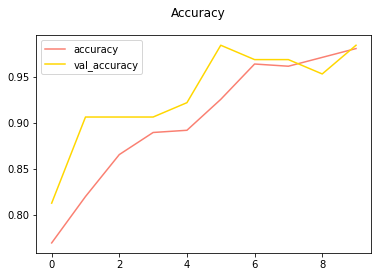

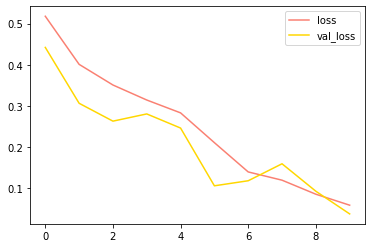

In [111]:
def plotting(history):
  fig = plt.figure()
  plt.plot(history.history['accuracy'], color = 'salmon', label = 'accuracy')
  plt.plot(history.history['val_accuracy'], color = 'gold', label = 'val_accuracy')
  fig.suptitle('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'], color = 'salmon', label = 'loss')
  plt.plot(history.history['val_loss'], color = 'gold', label = 'val_loss')
  fig.suptitle('Accuracy')
  plt.legend()
  plt.show()

plotting(hist)


In [57]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [58]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [59]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

1/1 [==============================] - 0s 478ms/step


In [63]:
print(f'Precision: {pre.result().numpy()}, recall: {re.result().numpy()}, accuracy: {acc.result().numpy()}')

Precision: 0.9714285731315613, recall: 0.9714285731315613, accuracy: 0.96875


#Test

In [65]:
!ls

bulldog  bulldog_test1.jpg  dachshund  dachshund_test1.jpg  logs


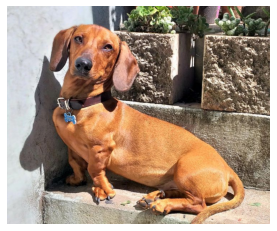

In [68]:
img = cv2.imread('dachshund_test1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()

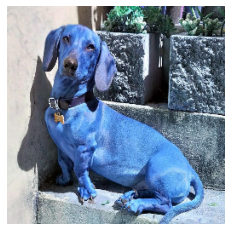

In [69]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.axis(False)
plt.show()

In [73]:
resize.shape, np.expand_dims(resize,0).shape

(TensorShape([256, 256, 3]), (1, 256, 256, 3))

In [74]:
import numpy as np
yhat = model.predict(np.expand_dims(resize/255.,0))


1/1 [==============================] - 0s 43ms/step


In [76]:
yhat

array([[0.9509967]], dtype=float32)

In [95]:
def label(yhat):
  if yhat > 0.5:
    return 'dachshund!'
  else:
    return 'bulldog!'

In [96]:
def predict_new_image(model, img):
  img = cv2.imread(img)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  resize = tf.image.resize(img, (256,256))
  y_hat = model.predict(np.expand_dims(resize/255.,0))
  plt.title(f'Predicted class: {label(y_hat)}')
  plt.axis(False)
  plt.show()  

1/1 [==============================] - 0s 67ms/step


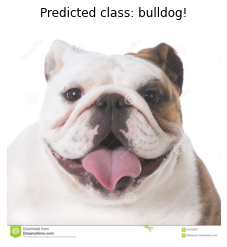

In [97]:
predict_new_image(model=model, img = 'bulldog_test1.jpg')

1/1 [==============================] - 0s 36ms/step


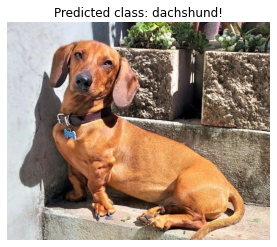

In [98]:
predict_new_image(model=model, img = 'dachshund_test1.jpg')

# Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.

In [131]:
model2 = tf.keras.Sequential([
    Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), 3, activation = 'relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation ='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model2.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch/4))
history2 = model2.fit(train, epochs=20, validation_data = val, callbacks = [lr_scheduler])

Epoch 1/20
13/13 [==============================] - 22s 1s/step - loss: 0.6887 - accuracy: 0.5649 - val_loss: 0.6632 - val_accuracy: 0.6094 - lr: 1.0000e-04
Epoch 2/20
13/13 [==============================] - 18s 1s/step - loss: 0.6644 - accuracy: 0.6010 - val_loss: 0.6349 - val_accuracy: 0.7656 - lr: 1.7783e-04
Epoch 3/20
13/13 [==============================] - 20s 1s/step - loss: 0.5951 - accuracy: 0.7380 - val_loss: 0.5212 - val_accuracy: 0.7500 - lr: 3.1623e-04
Epoch 4/20
13/13 [==============================] - 18s 1s/step - loss: 0.5732 - accuracy: 0.7115 - val_loss: 0.9539 - val_accuracy: 0.5781 - lr: 5.6234e-04
Epoch 5/20
13/13 [==============================] - 17s 1s/step - loss: 0.5290 - accuracy: 0.7524 - val_loss: 0.4914 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 6/20
13/13 [==============================] - 18s 1s/step - loss: 0.4448 - accuracy: 0.8221 - val_loss: 0.4514 - val_accuracy: 0.7500 - lr: 0.0018
Epoch 7/20
13/13 [==============================] - 17s 1s/step - 

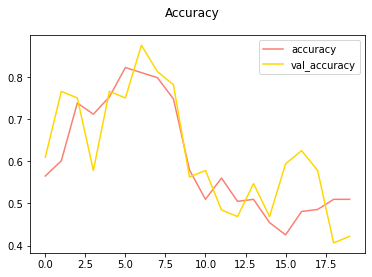

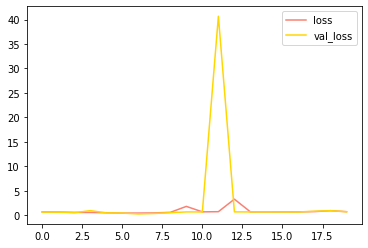

In [132]:
plotting(history2)

In [133]:
print(history2.history)

{'loss': [0.688718855381012, 0.6644156575202942, 0.595137894153595, 0.5732330083847046, 0.5290316343307495, 0.44477400183677673, 0.45609602332115173, 0.48668017983436584, 0.6006554961204529, 1.8198901414871216, 0.7003717422485352, 0.7361955046653748, 3.294783592224121, 0.6942071318626404, 0.6972474455833435, 0.7027683258056641, 0.6989800333976746, 0.7552323937416077, 0.9413076043128967, 0.7349888682365417], 'accuracy': [0.5649038553237915, 0.6009615659713745, 0.7379807829856873, 0.7115384340286255, 0.7524038553237915, 0.8221153616905212, 0.8100961446762085, 0.7980769276618958, 0.7475961446762085, 0.5793269276618958, 0.5096153616905212, 0.5600961446762085, 0.504807710647583, 0.5096153616905212, 0.45432692766189575, 0.42548078298568726, 0.48076921701431274, 0.48557692766189575, 0.5096153616905212, 0.5096153616905212], 'val_loss': [0.6632347702980042, 0.6348991394042969, 0.5211901068687439, 0.9538836479187012, 0.49140214920043945, 0.4514124393463135, 0.28092220425605774, 0.372131168842315

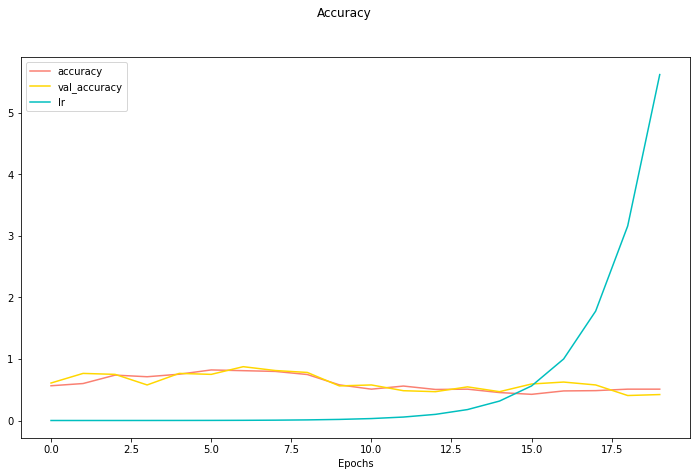

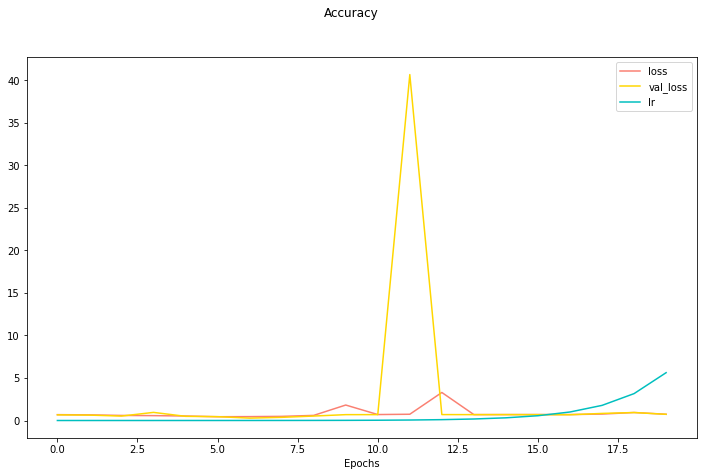

In [142]:

def plotting_lr(history):
  fig = plt.figure(figsize=(12,7))
  plt.plot(history.history['accuracy'], color = 'salmon', label = 'accuracy')
  plt.plot(history.history['val_accuracy'], color = 'gold', label = 'val_accuracy')
  plt.plot(history.history['lr'], color = 'c', label = 'lr')

  fig.suptitle('Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.show()

  fig = plt.figure(figsize=(12,7))
  plt.plot(history.history['loss'], color = 'salmon', label = 'loss')
  plt.plot(history.history['val_loss'], color = 'gold', label = 'val_loss')
  plt.plot(history.history['lr'], color = 'c', label = 'lr')

  fig.suptitle('Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.show()

plotting_lr(history2)


In [143]:
#model with best lr = 0.003
model3 = tf.keras.Sequential([
    Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), 3, activation = 'relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation ='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model3.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
               metrics = ['accuracy'])

history3 = model3.fit(train, epochs=20, validation_data = val)

Epoch 1/20
13/13 [==============================] - 19s 1s/step - loss: 0.8028 - accuracy: 0.5144 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 19s 1s/step - loss: 0.6864 - accuracy: 0.5697 - val_loss: 0.6518 - val_accuracy: 0.7812
Epoch 3/20
13/13 [==============================] - 17s 1s/step - loss: 0.5976 - accuracy: 0.7308 - val_loss: 0.4909 - val_accuracy: 0.7344
Epoch 4/20
13/13 [==============================] - 17s 1s/step - loss: 0.5227 - accuracy: 0.7668 - val_loss: 0.4215 - val_accuracy: 0.8281
Epoch 5/20
13/13 [==============================] - 18s 1s/step - loss: 0.4778 - accuracy: 0.7885 - val_loss: 0.5076 - val_accuracy: 0.7188
Epoch 6/20
13/13 [==============================] - 17s 1s/step - loss: 0.4483 - accuracy: 0.8149 - val_loss: 0.3969 - val_accuracy: 0.8125
Epoch 7/20
13/13 [==============================] - 20s 1s/step - loss: 0.4912 - accuracy: 0.7620 - val_loss: 0.4006 - val_accuracy: 0.8438
Epoch 8/20
13/13 [==

1/1 [==============================] - 0s 293ms/step


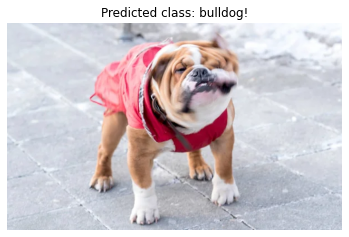

In [153]:
predict_new_image(model3,'bulldog_test2.jpg')

1/1 [==============================] - 0s 49ms/step


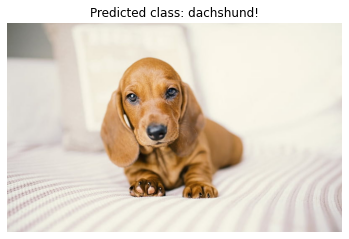

In [154]:
predict_new_image(model3, 'dachshund_test2.jpg')